# Spotify Genre Classification EDA

## Initializations

In [48]:
%matplotlib inline
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time


In [49]:
os.environ["SPOTIPY_CACHE"] = "/tmp/spotipy_cache"  # or any valid writable path

In [50]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.exceptions import SpotifyException

client_id = 'e7ea4d9a3158410c99bfc1d6adb0bd48'
client_secret = '511714788e874b6f9bfbf0c9709c938a'

client_credentials_manager = SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret
)

sp = spotipy.Spotify(auth=client_credentials_manager.get_access_token(as_dict=False))

# Authenticate with Spotify API
#sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

# Test
result = sp.search(q='breath away', type='track', limit=1)
result

{'tracks': {'href': 'https://api.spotify.com/v1/search?offset=0&limit=1&query=breath%20away&type=track',
  'limit': 1,
  'next': 'https://api.spotify.com/v1/search?offset=1&limit=1&query=breath%20away&type=track',
  'offset': 0,
  'previous': None,
  'total': 900,
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/0PCCGZ0wGLizHt2KZ7hhA2'},
       'href': 'https://api.spotify.com/v1/artists/0PCCGZ0wGLizHt2KZ7hhA2',
       'id': '0PCCGZ0wGLizHt2KZ7hhA2',
       'name': 'Artemas',
       'type': 'artist',
       'uri': 'spotify:artist:0PCCGZ0wGLizHt2KZ7hhA2'}],
     'available_markets': ['AR',
      'AU',
      'AT',
      'BE',
      'BO',
      'BR',
      'BG',
      'CA',
      'CL',
      'CO',
      'CR',
      'CY',
      'CZ',
      'DK',
      'DO',
      'DE',
      'EC',
      'EE',
      'SV',
      'FI',
      'FR',
      'GR',
      'GT',
      'HN',
      'HK',
      'HU',
      'IS',
      'IE',
   

## Data Loading and Preprocessing

In [51]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load the dataset as a pandas DataFrame
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "iamsumat/spotify-top-2000s-mega-dataset",
    "Spotify-2000.csv",  # Replace with the correct file name from the dataset
)

# Display the first 5 records
print("First 5 records:")
df.head()

First 5 records:


Index                   Title             Artist            Top Genre  \
0      1                 Sunrise        Norah Jones      adult standards   
1      2             Black Night        Deep Purple           album rock   
2      3          Clint Eastwood           Gorillaz  alternative hip hop   
3      4           The Pretender       Foo Fighters    alternative metal   
4      5  Waitin' On A Sunny Day  Bruce Springsteen         classic rock   

   Year  Beats Per Minute (BPM)  Energy  Danceability  Loudness (dB)  \
0  2004                     157      30            53            -14   
1  2000                     135      79            50            -11   
2  2001                     168      69            66             -9   
3  2007                     173      96            43             -4   
4  2002                     106      82            58             -5   

   Liveness  Valence Length (Duration)  Acousticness  Speechiness  Popularity  
0        11       68               201            94            3          71  
1        17       81               207            17            7          39  
2         7       52               341             2           17          69  
3         3       37               269             0            4          76  
4        10       87               256             1            3          59

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Index                   1994 non-null   int64 
 1   Title                   1994 non-null   object
 2   Artist                  1994 non-null   object
 3   Top Genre               1994 non-null   object
 4   Year                    1994 non-null   int64 
 5   Beats Per Minute (BPM)  1994 non-null   int64 
 6   Energy                  1994 non-null   int64 
 7   Danceability            1994 non-null   int64 
 8   Loudness (dB)           1994 non-null   int64 
 9   Liveness                1994 non-null   int64 
 10  Valence                 1994 non-null   int64 
 11  Length (Duration)       1994 non-null   object
 12  Acousticness            1994 non-null   int64 
 13  Speechiness             1994 non-null   int64 
 14  Popularity              1994 non-null   int64 
dtypes: i

In [53]:
df.index = df['Index']
df = df.drop(columns='Index')
df.head()

Title             Artist            Top Genre  Year  \
Index                                                                         
1                     Sunrise        Norah Jones      adult standards  2004   
2                 Black Night        Deep Purple           album rock  2000   
3              Clint Eastwood           Gorillaz  alternative hip hop  2001   
4               The Pretender       Foo Fighters    alternative metal  2007   
5      Waitin' On A Sunny Day  Bruce Springsteen         classic rock  2002   

       Beats Per Minute (BPM)  Energy  Danceability  Loudness (dB)  Liveness  \
Index                                                                          
1                         157      30            53            -14        11   
2                         135      79            50            -11        17   
3                         168      69            66             -9         7   
4                         173      96            43             -4         3   
5                         106      82            58             -5        10   

       Valence Length (Duration)  Acousticness  Speechiness  Popularity  
Index                                                                    
1           68               201            94            3          71  
2           81               207            17            7          39  
3           52               341             2           17          69  
4           37               269             0            4          76  
5           87               256             1            3          59

In [54]:
df.describe()

Year  Beats Per Minute (BPM)       Energy  Danceability  \
count  1994.000000             1994.000000  1994.000000   1994.000000   
mean   1992.992979              120.215647    59.679539     53.238215   
std      16.116048               28.028096    22.154322     15.351507   
min    1956.000000               37.000000     3.000000     10.000000   
25%    1979.000000               99.000000    42.000000     43.000000   
50%    1993.000000              119.000000    61.000000     53.000000   
75%    2007.000000              136.000000    78.000000     64.000000   
max    2019.000000              206.000000   100.000000     96.000000   

       Loudness (dB)     Liveness      Valence  Acousticness  Speechiness  \
count    1994.000000  1994.000000  1994.000000   1994.000000  1994.000000   
mean       -9.008526    19.012036    49.408726     28.858074     4.994985   
std         3.647876    16.727378    24.858212     29.011986     4.401566   
min       -27.000000     2.000000     3.000000      0.000000     2.000000   
25%       -11.000000     9.000000    29.000000      3.000000     3.000000   
50%        -8.000000    12.000000    47.000000     18.000000     4.000000   
75%        -6.000000    23.000000    69.750000     50.000000     5.000000   
max        -2.000000    99.000000    99.000000     99.000000    55.000000   

       Popularity  
count  1994.00000  
mean     59.52658  
std      14.35160  
min      11.00000  
25%      49.25000  
50%      62.00000  
75%      71.00000  
max     100.00000

In [55]:
df.describe(include='object')

Title Artist   Top Genre Length (Duration)
count   1994   1994        1994              1994
unique  1958    731         149               350
top      One  Queen  album rock               215
freq       3     37         413                23

Length (Duration) needs to be typed as an int. There are 149 unique values for 'Top Genre', 731 unique values for 'Artist', and 1958 unique values for 'Title'. Since we're exploring the statistics and data for unique genres we should limit the genres to the most popular genres or provide widgets that can toggle the number of genres.

In [56]:
df.duplicated().sum()

0

In [57]:
df.isna().sum()

Title                     0
Artist                    0
Top Genre                 0
Year                      0
Beats Per Minute (BPM)    0
Energy                    0
Danceability              0
Loudness (dB)             0
Liveness                  0
Valence                   0
Length (Duration)         0
Acousticness              0
Speechiness               0
Popularity                0
dtype: int64

In [58]:
df.sample(10, random_state=42)

Title              Artist  \
Index                                                              
890                         Time In A Bottle           Jim Croce   
1673              Ik Leef Niet Meer Voor Jou       Marco Borsato   
415                        A Night Like This        Caro Emerald   
1600                      Rhythm Is A Dancer               SNAP!   
850                              Wild Horses  The Rolling Stones   
1659   Streets of Philadelphia - Single Edit   Bruce Springsteen   
927          Tequila Sunrise - 2013 Remaster              Eagles   
1671                              Lemon Tree        Fools Garden   
1449                          Ich bin wie du  Marianne Rosenberg   
1217   Belgie ... (Is Er Leven Op Pluto ...)      Het Goede Doel   

              Top Genre  Year  Beats Per Minute (BPM)  Energy  Danceability  \
Index                                                                         
890     adult standards  1972                     134      26            54   
1673      dutch cabaret  1995                     150      82            55   
415           dutch pop  2010                     123      71            87   
1600         diva house  1992                     124      65            76   
850          album rock  1971                     140      39            43   
1659       classic rock  1995                      94      29            74   
927          album rock  1973                     111      40            63   
1671    german pop rock  1995                     143      48            66   
1449   classic schlager  1988                     129      74            48   
1217          dutch pop  1982                     141      66            58   

       Loudness (dB)  Liveness  Valence Length (Duration)  Acousticness  \
Index                                                                     
890              -12        15       64               148            85   
1673              -9         4       57               217             2   
415               -6        10       96               226            57   
1600             -15         9       86               332            21   
850               -7         8       16               342            69   
1659             -13         9       44               195            29   
927              -13        11       73               173            54   
1671              -9        12       64               191            64   
1449             -10         5       60               218             1   
1217             -14         7       66               361             1   

       Speechiness  Popularity  
Index                           
890              3          58  
1673             5          60  
415              4          40  
1600             3          57  
850              3          72  
1659             3          70  
927              3          62  
1671             4          73  
1449             8          45  
1217             4          52

In [59]:
df['Length (Duration)'].unique()

array(['201', '207', '341', '269', '256', '247', '257', '366', '223',
       '290', '162', '232', '214', '639', '173', '236', '288', '276',
       '352', '296', '218', '176', '197', '261', '270', '298', '259',
       '306', '310', '211', '186', '185', '264', '202', '263', '266',
       '629', '177', '237', '278', '331', '355', '213', '234', '216',
       '275', '467', '243', '219', '305', '215', '144', '195', '240',
       '357', '297', '281', '273', '212', '279', '249', '229', '394',
       '375', '226', '210', '258', '283', '231', '268', '403', '321',
       '217', '308', '206', '208', '242', '326', '199', '225', '193',
       '302', '294', '238', '433', '324', '154', '245', '248', '311',
       '272', '289', '253', '181', '184', '203', '280', '146', '196',
       '204', '602', '353', '189', '423', '233', '135', '141', '241',
       '262', '346', '319', '284', '501', '287', '170', '187', '171',
       '414', '252', '209', '364', '246', '235', '161', '274', '286',
       '172', '404',

In [60]:
pd.to_numeric(df['Length (Duration)'], errors='coerce').isna().sum()

4

When these strings are forced into numeric types, four NaNs result from that method.

In [61]:
df['Length (Duration)'] = df['Length (Duration)'].str.replace(',','')

In [62]:
df['Length (Duration)'].unique()

array(['201', '207', '341', '269', '256', '247', '257', '366', '223',
       '290', '162', '232', '214', '639', '173', '236', '288', '276',
       '352', '296', '218', '176', '197', '261', '270', '298', '259',
       '306', '310', '211', '186', '185', '264', '202', '263', '266',
       '629', '177', '237', '278', '331', '355', '213', '234', '216',
       '275', '467', '243', '219', '305', '215', '144', '195', '240',
       '357', '297', '281', '273', '212', '279', '249', '229', '394',
       '375', '226', '210', '258', '283', '231', '268', '403', '321',
       '217', '308', '206', '208', '242', '326', '199', '225', '193',
       '302', '294', '238', '433', '324', '154', '245', '248', '311',
       '272', '289', '253', '181', '184', '203', '280', '146', '196',
       '204', '602', '353', '189', '423', '233', '135', '141', '241',
       '262', '346', '319', '284', '501', '287', '170', '187', '171',
       '414', '252', '209', '364', '246', '235', '161', '274', '286',
       '172', '404',

In [63]:
pd.to_numeric(df['Length (Duration)'], errors='raise')

Index
1       201
2       207
3       341
4       269
5       256
       ... 
1990    128
1991    136
1992    162
1993    324
1994    148
Name: Length (Duration), Length: 1994, dtype: int64

In [64]:
print(df['Length (Duration)'].sort_values(ascending=False).values, end=' ')

['966' '93' '859' ... '1121' '108' '102'] 

In [65]:
df['Length (Duration)'].dtype

dtype('O')

In [66]:
df.loc[1050,'Length (Duration)']

'93'

In [67]:
pd.to_numeric(df['Length (Duration)'], errors='raise').astype(str).eq(df['Length (Duration)']).all()

True

We have confirmation that changing the df['Length (Duration)'] into ints will not change any of the values, just the datatypes.

In [68]:
df['Length (Duration)'] = pd.to_numeric(df['Length (Duration)'], errors='coerce')

In [69]:
df['Length (Duration)'].isna().sum()

0

## Text Based Grouping via NLP

In [70]:
#Number of categories is excessive.  link related ones together. 
# Extract unique genres
unique_genres = df['Top Genre'].unique()

# Convert genre text into TF-IDF vectors
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(unique_genres)

# Cluster genre names into broader groups
n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X)

#Map original genres to cluster numbers
genre_to_cluster = dict(zip(unique_genres, cluster_labels))
df['Genre Cluster ID'] = df['Top Genre'].map(genre_to_cluster)

In [71]:
# See which genres were grouped together
genre_clusters = pd.DataFrame({'Genre': unique_genres, 'Cluster': cluster_labels})
for i in range(n_clusters):
    print(f"\nCluster {i}:")
    print(genre_clusters[genre_clusters['Cluster'] == i]['Genre'].tolist())


Cluster 0:
['acid jazz', 'contemporary vocal jazz', 'latin jazz']

Cluster 1:
['adult standards', 'alternative hip hop', 'pop', 'detroit hip hop', 'dutch indie', 'dutch cabaret', 'permanent wave', 'classic uk pop', 'dance pop', 'dutch pop', 'dutch americana', 'german pop', 'afropop', 'disco', 'big room', 'britpop', 'boy band', 'carnaval limburg', 'arkansas country', 'british folk', 'celtic', 'chanson', 'hip pop', 'east coast hip hop', 'electro', 'australian pop', 'downtempo', 'reggae fusion', 'british invasion', 'canadian pop', 'bow pop', 'dutch hip hop', 'acoustic pop', 'dutch prog', 'candy pop', 'operatic pop', 'trance', 'scottish singer-songwriter', 'mellow gold', 'atl hip hop', 'eurodance', 'blues', 'canadian folk', 'big beat', 'art pop', 'uk pop', 'brill building pop', 'g funk', 'happy hardcore', 'belgian pop', 'classic schlager', 'contemporary country', 'barbadian pop', 'gabba', 'chamber pop', 'british singer-songwriter', 'indie pop', 'nederpop', 'australian indie folk', 'folk-p

In [72]:
#reviewed created clusters.  correct some errors
genre_to_cluster['alternative dance', 'latin alternative','alternative pop', 'alterrnative country'] = 1 

In [73]:
# Label clusters based on inspection of what genres fell into each
cluster_id_to_name = {
    0: 'Jazz',
    1: 'Pop',
    2: 'Rock',
    3: 'Soul',
    4: 'Metal'
}

In [74]:
# Reapply the mapping
df['Genre Cluster ID'] = df['Top Genre'].map(genre_to_cluster)
df['Genre Group'] = df['Genre Cluster ID'].map(cluster_id_to_name)

In [75]:
# Create final human-readable cluster label
df['Genre Group'] = df['Genre Cluster ID'].map(cluster_id_to_name)

In [76]:
df.head()

Title             Artist            Top Genre  Year  \
Index                                                                         
1                     Sunrise        Norah Jones      adult standards  2004   
2                 Black Night        Deep Purple           album rock  2000   
3              Clint Eastwood           Gorillaz  alternative hip hop  2001   
4               The Pretender       Foo Fighters    alternative metal  2007   
5      Waitin' On A Sunny Day  Bruce Springsteen         classic rock  2002   

       Beats Per Minute (BPM)  Energy  Danceability  Loudness (dB)  Liveness  \
Index                                                                          
1                         157      30            53            -14        11   
2                         135      79            50            -11        17   
3                         168      69            66             -9         7   
4                         173      96            43             -4         3   
5                         106      82            58             -5        10   

       Valence  Length (Duration)  Acousticness  Speechiness  Popularity  \
Index                                                                      
1           68                201            94            3          71   
2           81                207            17            7          39   
3           52                341             2           17          69   
4           37                269             0            4          76   
5           87                256             1            3          59   

       Genre Cluster ID Genre Group  
Index                                
1                     1         Pop  
2                     2        Rock  
3                     1         Pop  
4                     4       Metal  
5                     2        Rock

## EDA

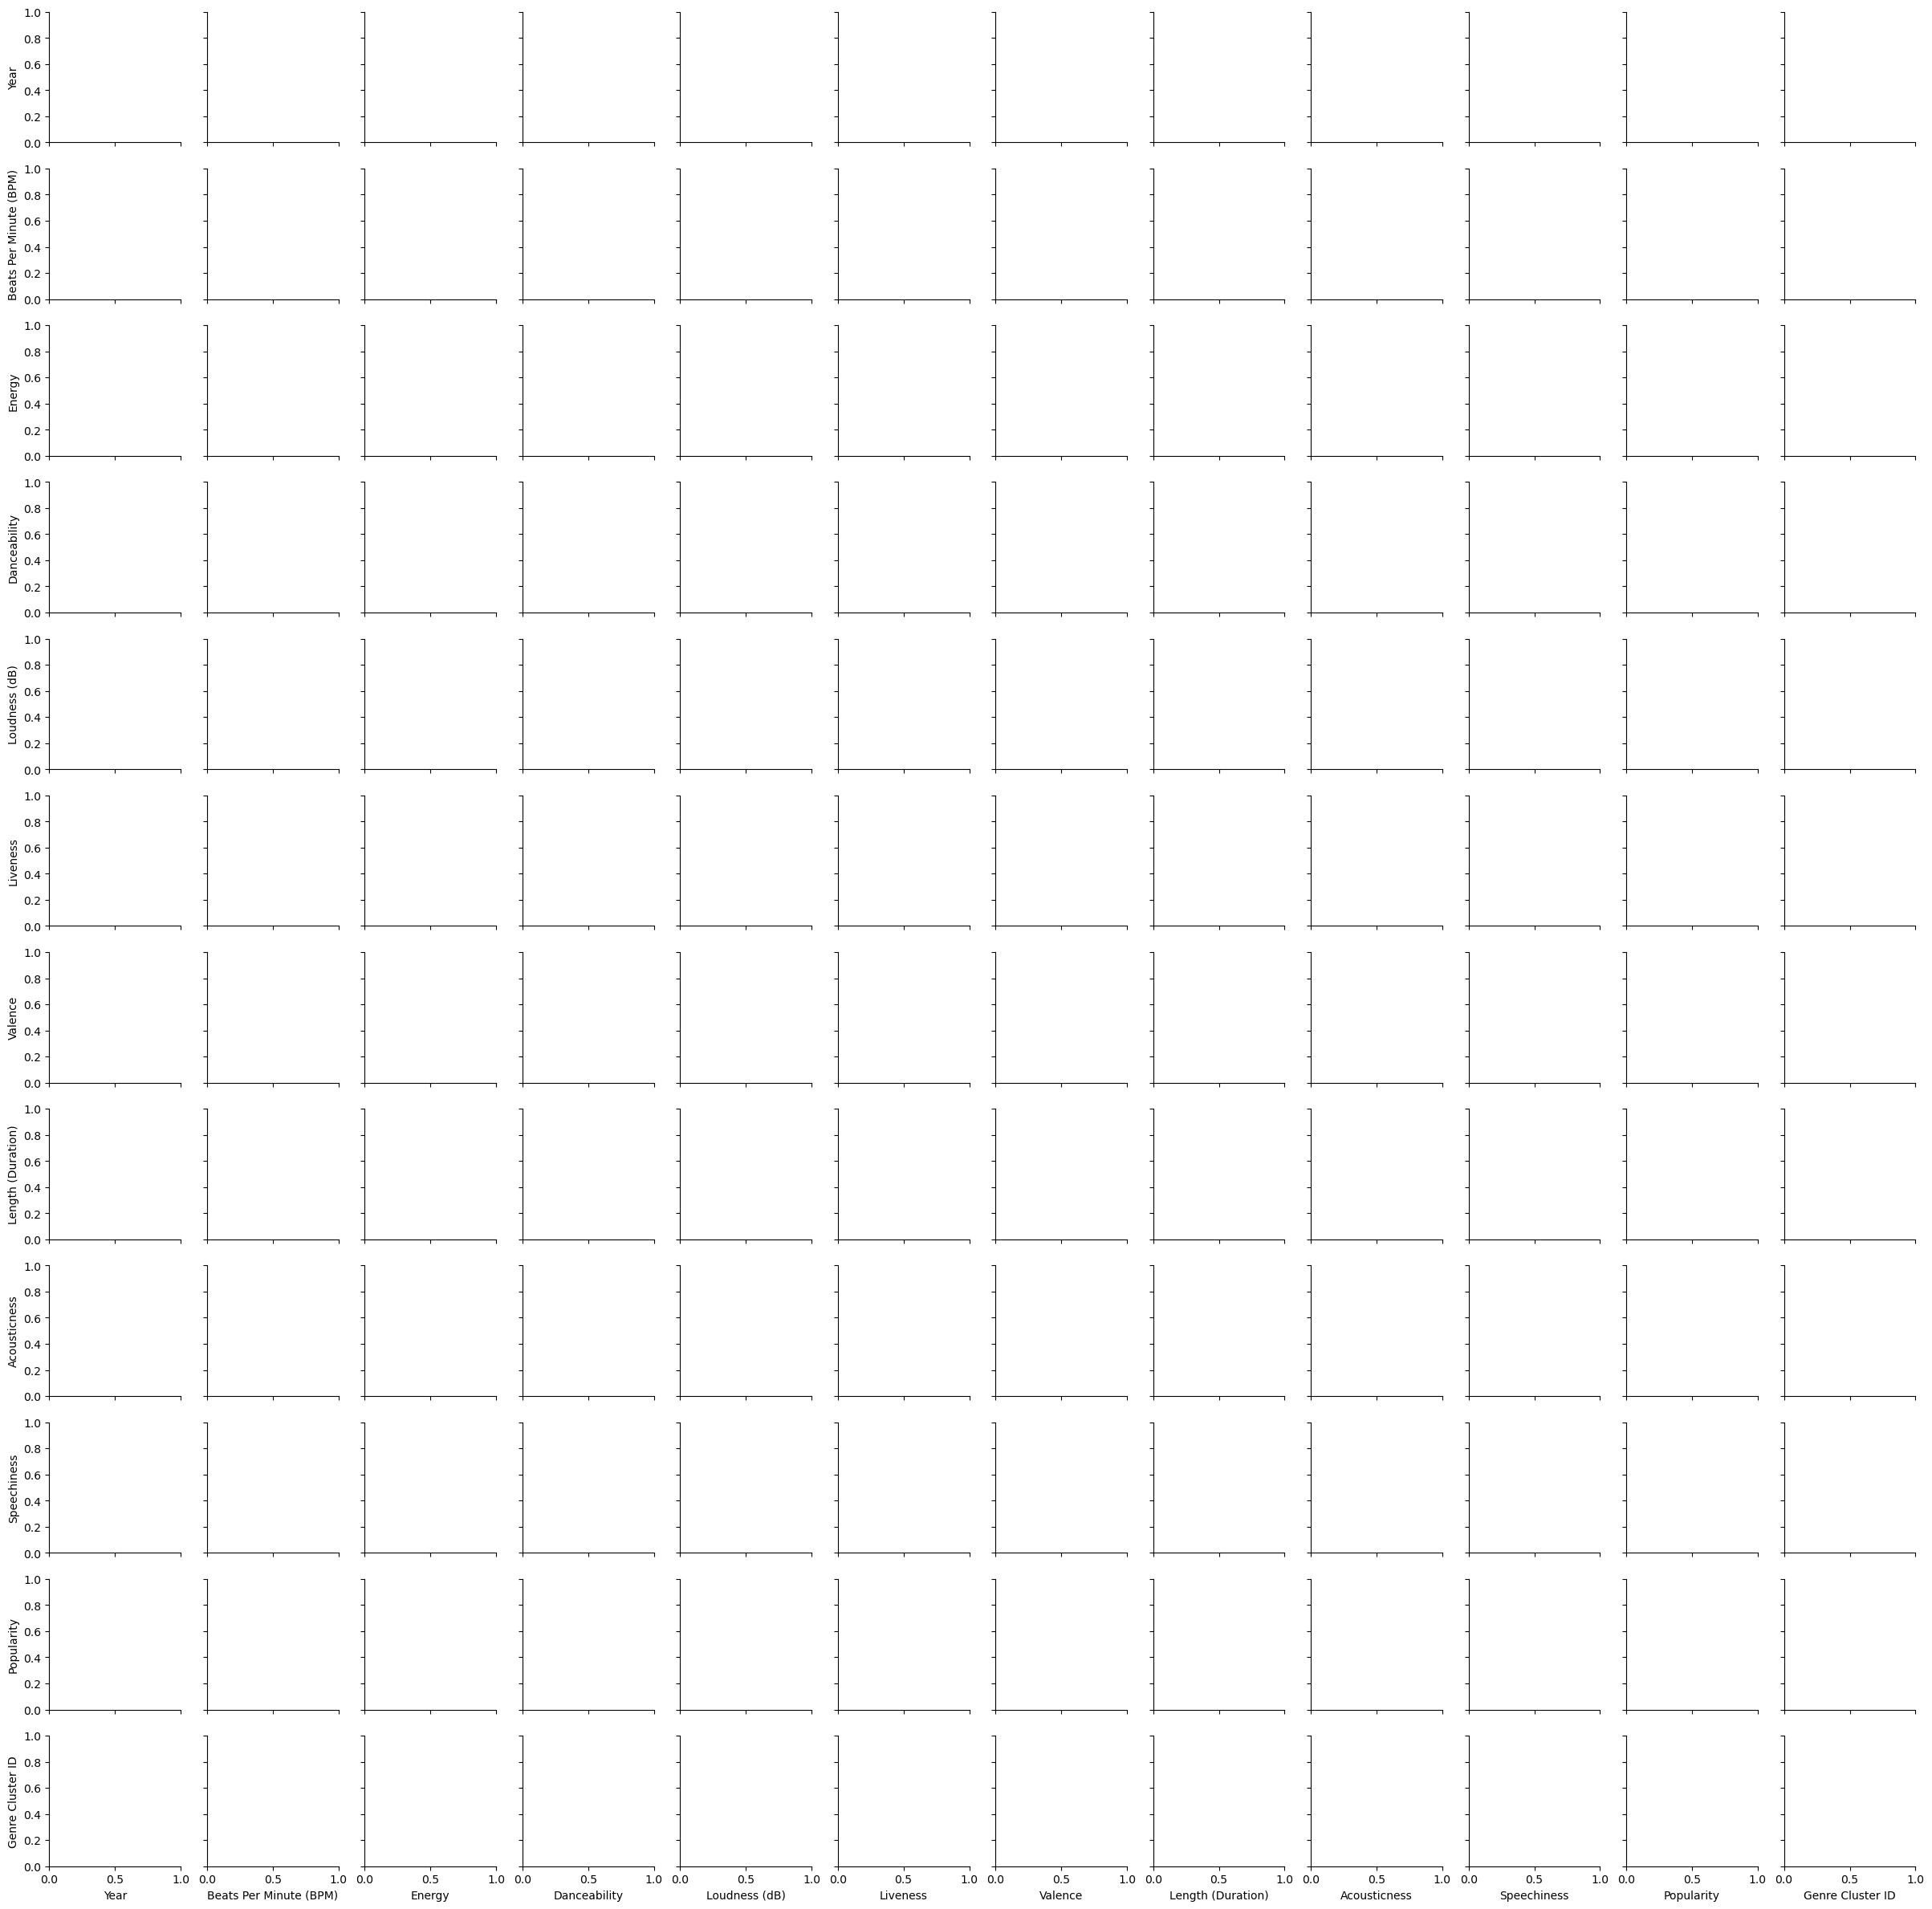

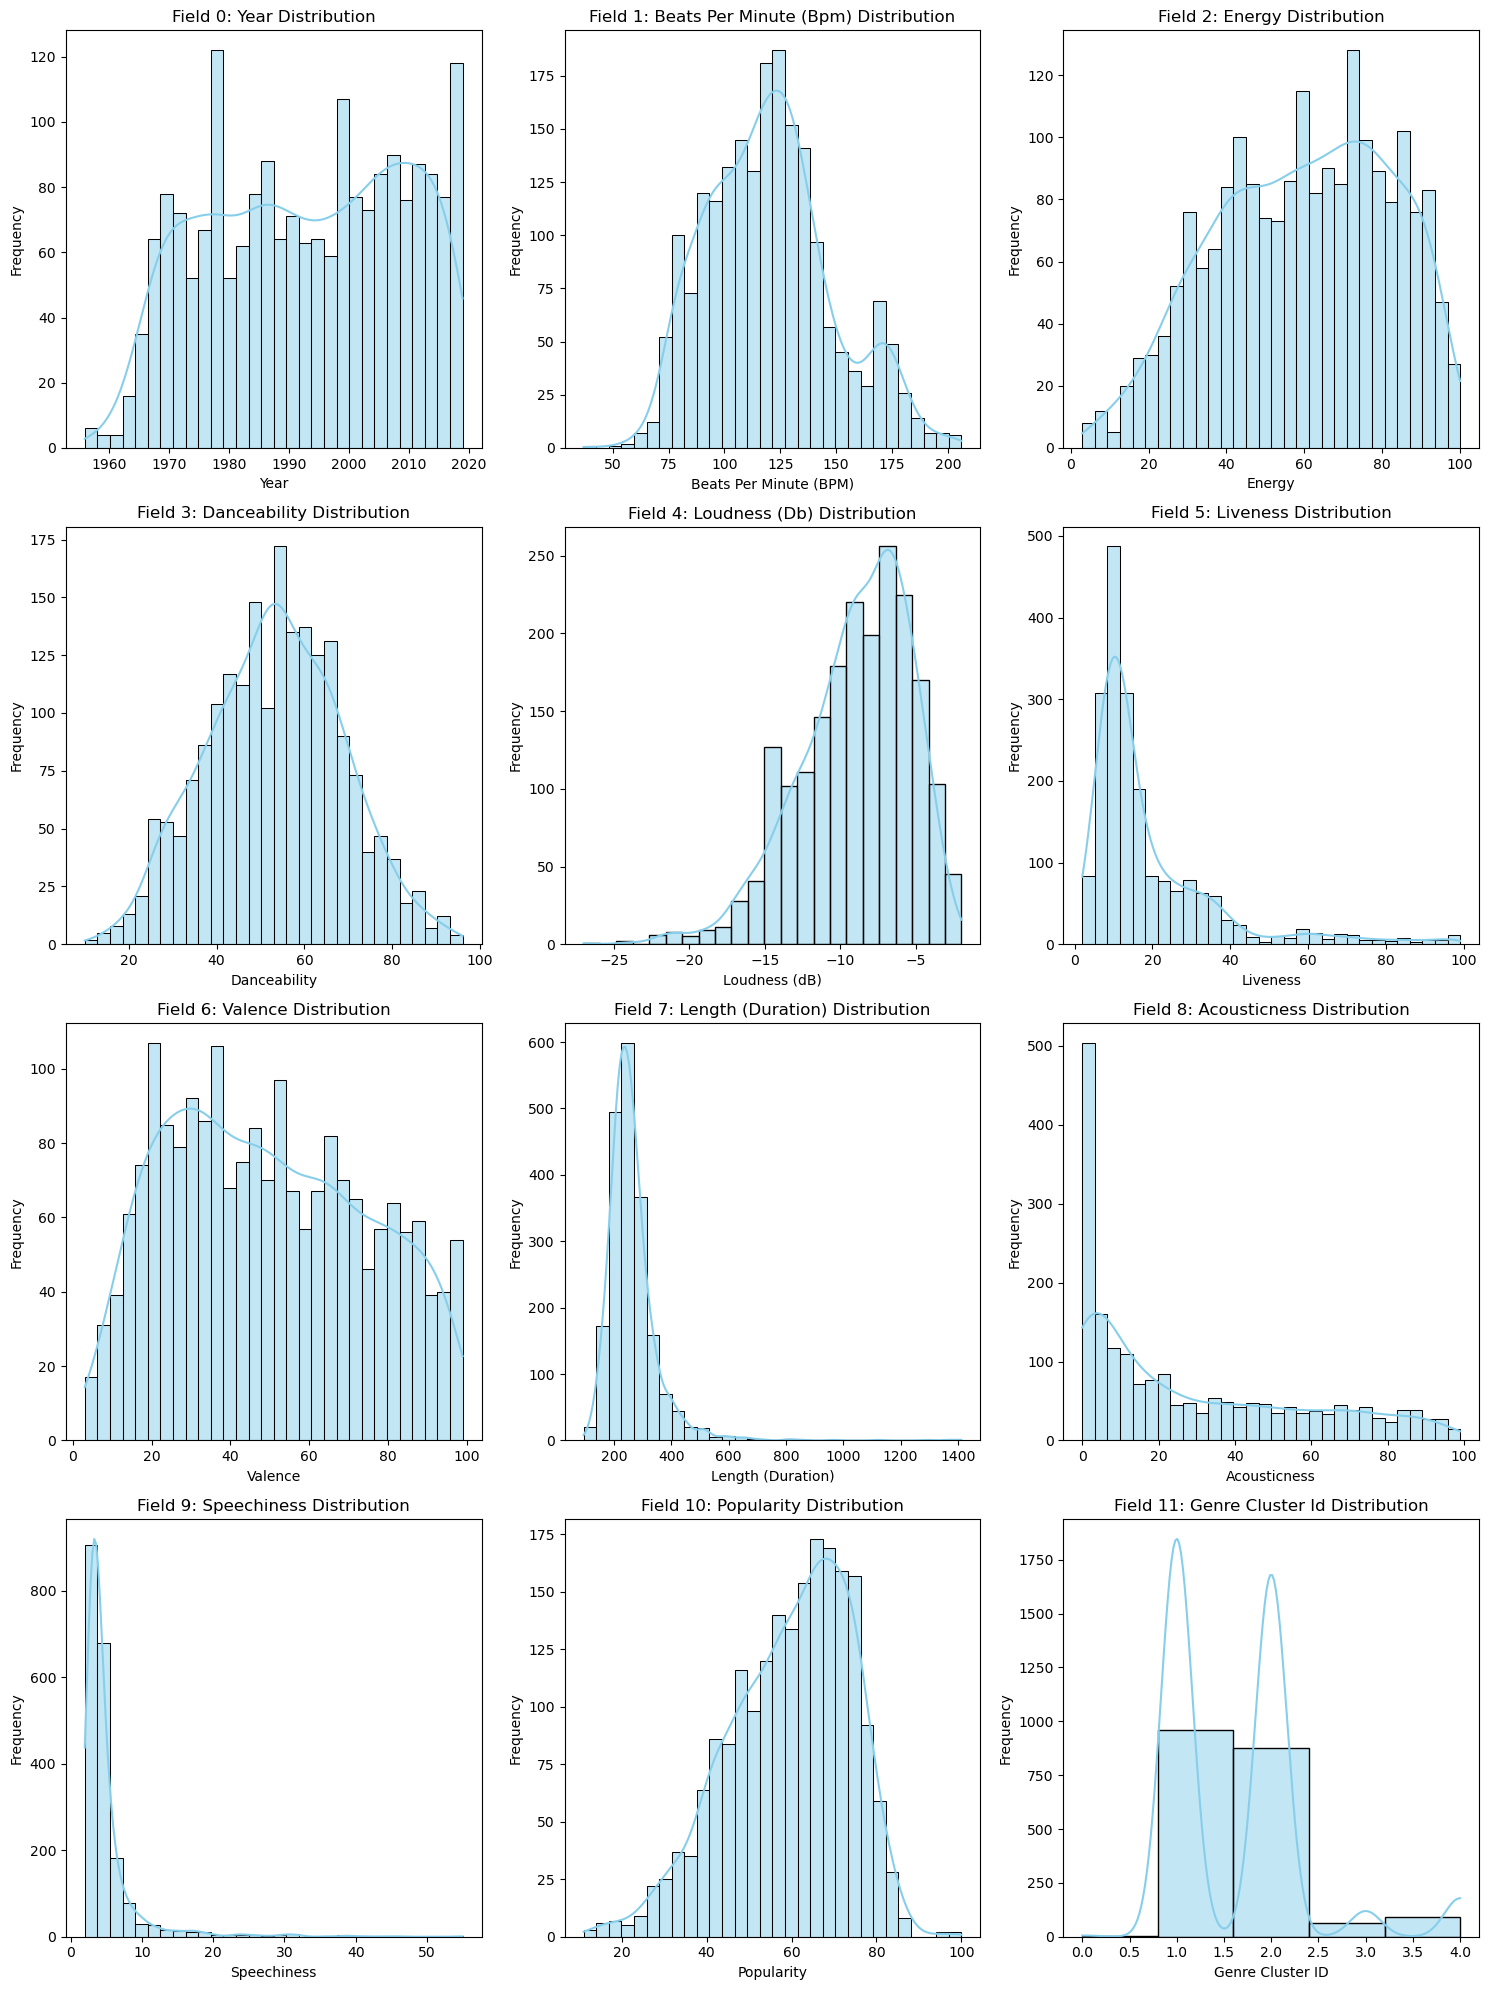

In [77]:
# Get all numeric column names
numeric_columns = df.select_dtypes(include=['number']).columns  # Select only numeric columns

# Set up the number of rows and columns for subplots
n = len(numeric_columns)
cols = 3  # Number of columns for subplots
rows = (n + cols - 1) // cols  # Calculate the number of rows needed

# Create the figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten the axes array to make it easier to iterate
i = 0 

# Plot a histogram for each numeric column
for i, col in enumerate(numeric_columns):
    bins = 30
    if df[col].unique().sum() < bins and df[col].nunique() >= 1:
        bins = df[col].nunique()
    sns.histplot(df[col], kde=True, ax=axes[i], bins=bins, color='skyblue', edgecolor='black')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Field {i}: {col.title()} Distribution')

# Hide any extra subplots if the numeric columns are not divisible by three.
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust the layout to ensure there's no overlap
plt.tight_layout()

# Show the figure
plt.show()

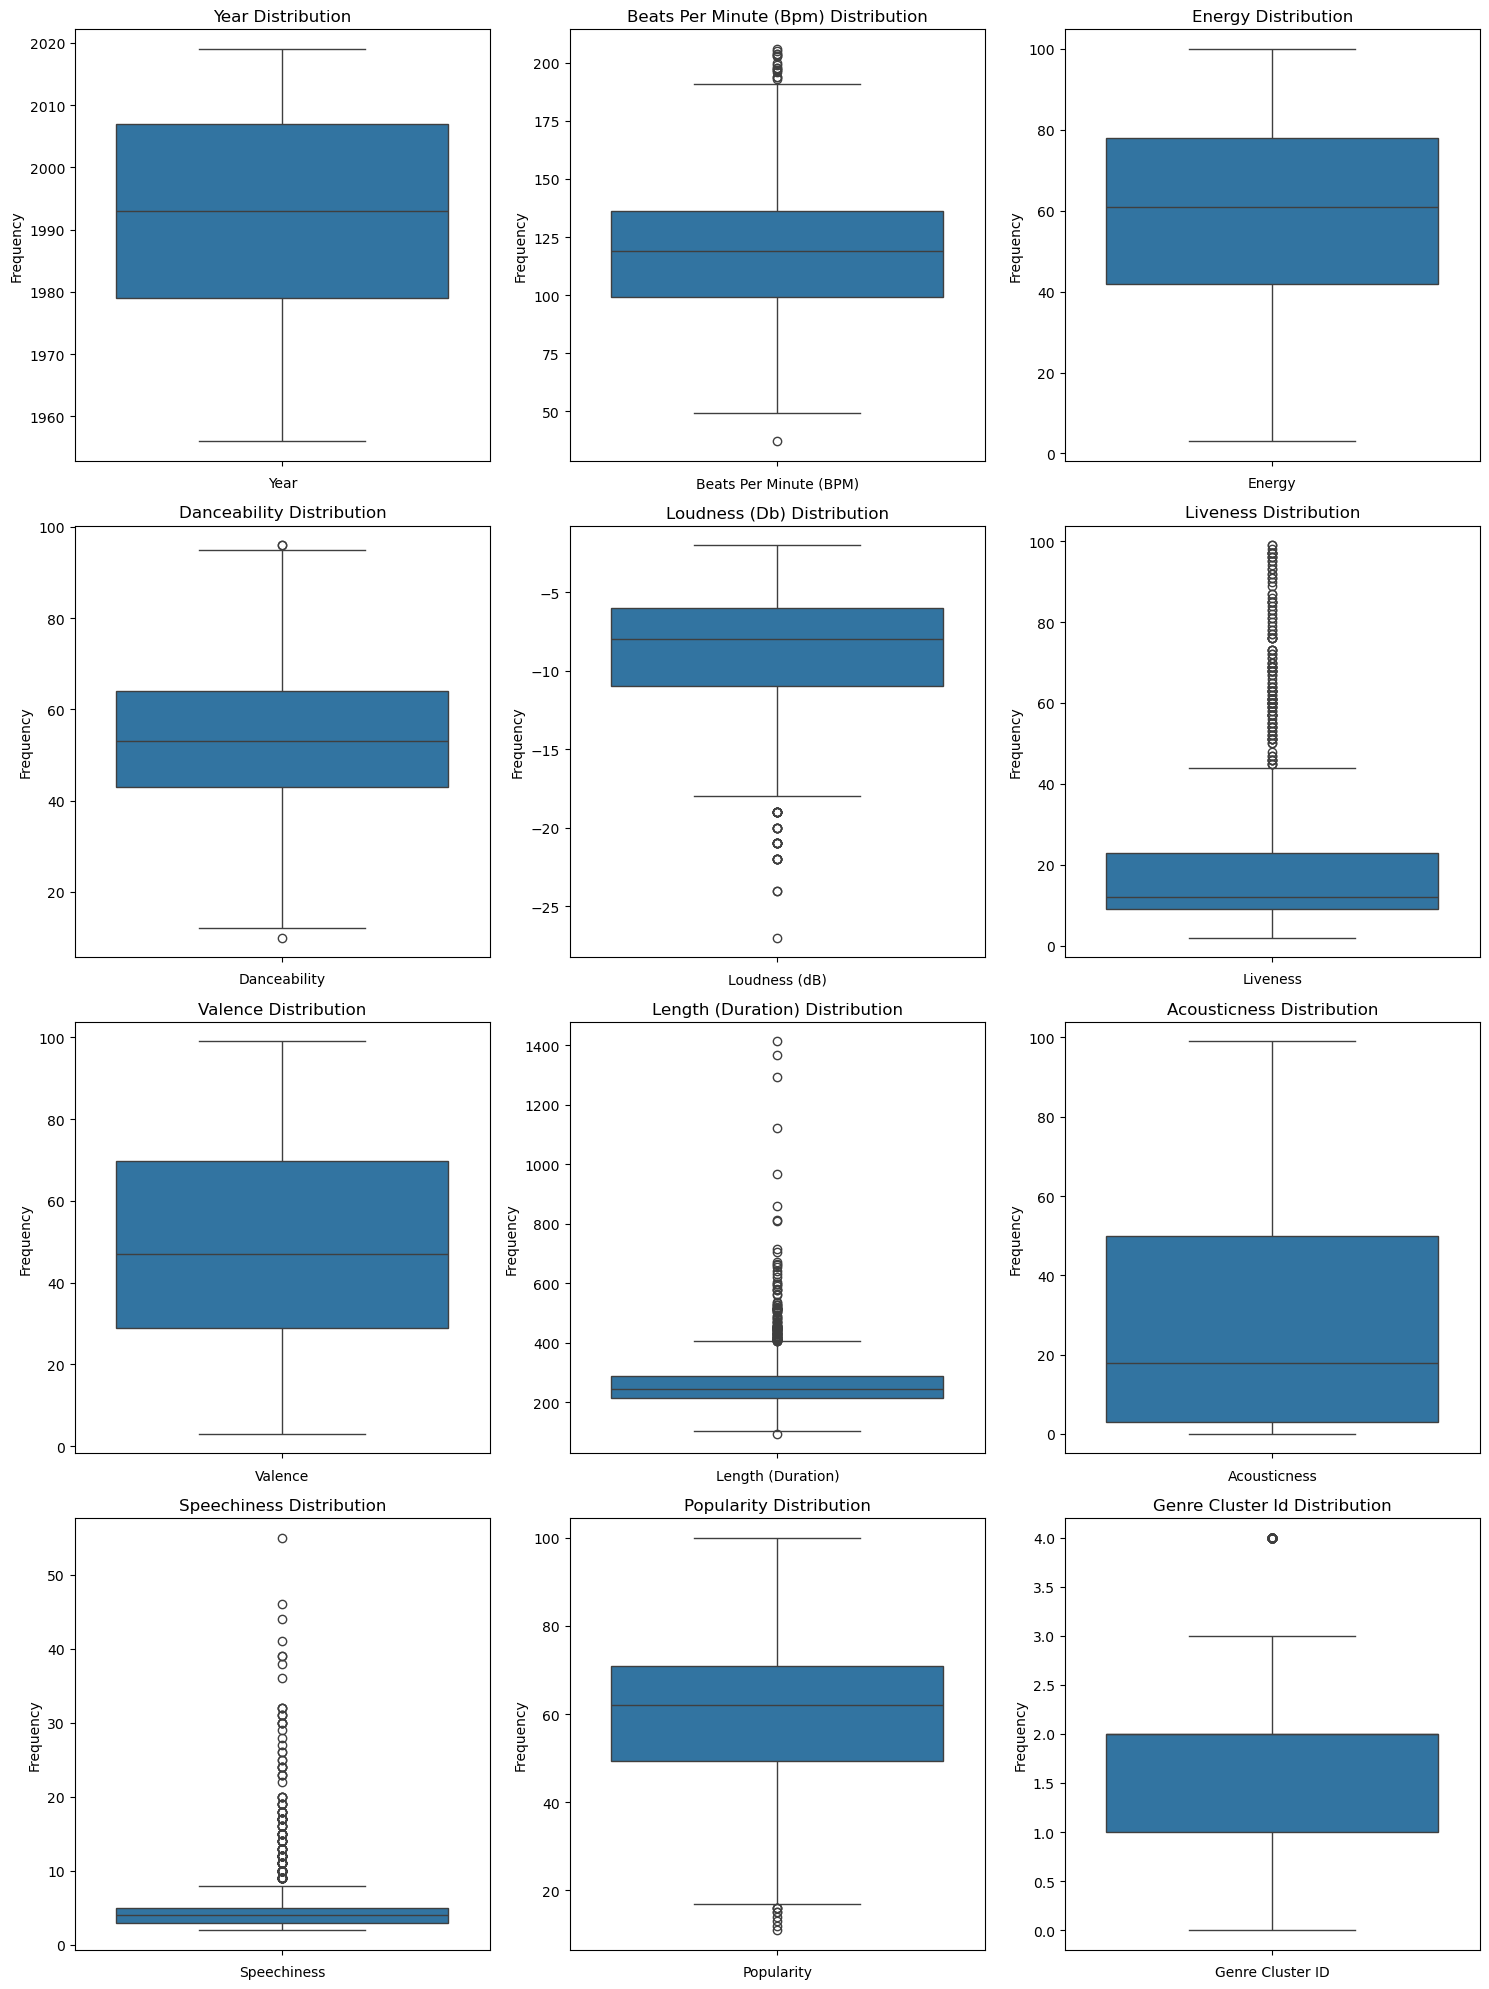

In [78]:
numeric_columns = df.select_dtypes(include=[np.number]).columns  # Select only numeric columns

# Set up the number of rows and columns for subplots
n = len(numeric_columns)
cols = 3  # Number of columns for subplots
rows = (n + cols - 1) // cols  # Calculate the number of rows needed

# Create the figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten the axes array to make it easier to iterate

# Plot a boxplot for each numeric column
for i, col in enumerate(numeric_columns):
    sns.boxplot(df[col], ax=axes[i], patch_artist=True)  # Specify ax for each boxplot
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'{col.title()} Distribution')
    
# Hide any extra subplots if the numeric columns are not divisible by three.
for j in range(i + 1, len(axes)):
   axes[j].axis('off')

# Adjust the layout to ensure there's no overlap
plt.tight_layout()

# Show the figure
plt.show()

We do have outliers in the dataset, but given that the data was selected based on the popularity of these songs on the Spotify streaming platform, outliers are likely to be representative of different eras or genres of music. They do not represent a problem with the way the data was collected and do not need to be removed at this point.

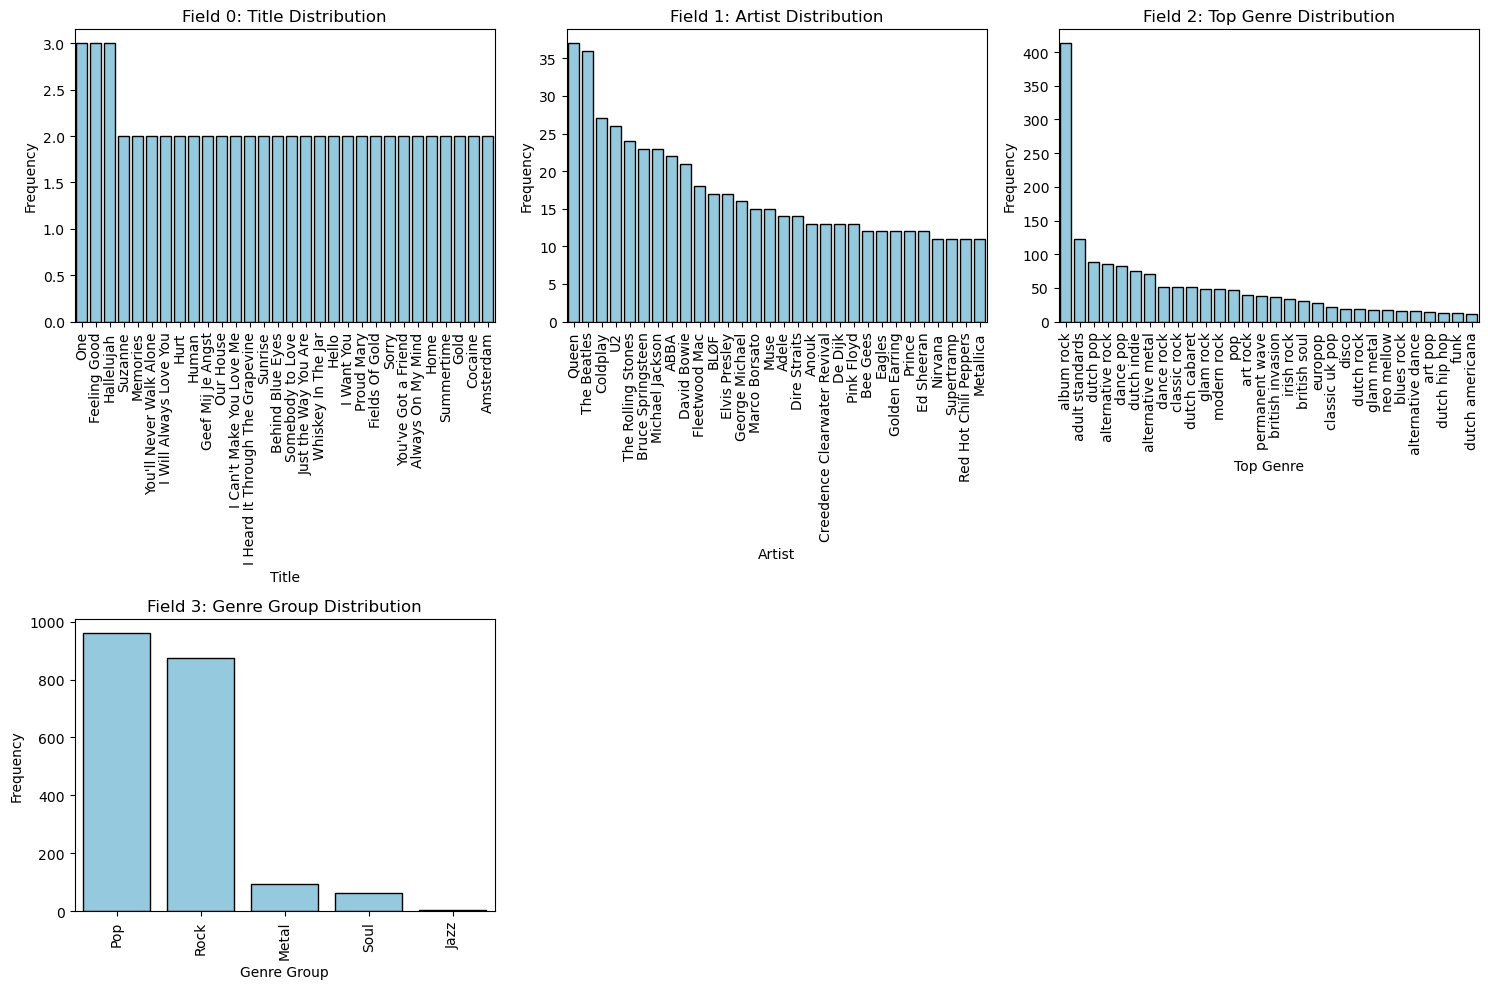

In [79]:
# We do not want to plot endless or referencial text like links.
top_n = 30  # Top N values to display

# Get object columns only from the selected ones
object_columns = df.select_dtypes(include=['object']).columns  # Select only object columns

# Set up the number of rows and columns for subplots
n = len(object_columns)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

# Plot count plots for each object column
for i, col in enumerate(object_columns):
    top_values = df[col].value_counts(ascending=False).nlargest(top_n).index
    filtered_df = df[df[col].isin(top_values)].sort_values(col, ascending=False)
    
    sns.countplot(data=filtered_df, x=col, ax=axes[i], color='skyblue', edgecolor='black', order=top_values)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Field {i}: {col.title()} Distribution')
    axes[i].tick_params(axis='x', rotation=90)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

These plots represent the various frequencies of the strings in the dataset. As a field, 'Title' isn't very useful, but 'Artist' and 'Top Genre' are at very least informative. Given that the 'Top Genre' will be the target for our ML models, the high class imbalance between 'Album Rock' and the rest of the dataset could be quite problematic.

In [80]:
numeric_columns

Index(['Year', 'Beats Per Minute (BPM)', 'Energy', 'Danceability',
       'Loudness (dB)', 'Liveness', 'Valence', 'Length (Duration)',
       'Acousticness', 'Speechiness', 'Popularity', 'Genre Cluster ID'],
      dtype='object')

In [81]:
len(df.columns)

16

In [82]:
numeric_columns = df.select_dtypes(include='number').columns.tolist()
n = len(numeric_columns)
cols = 3
rows = -(-n // 3)

fig = make_subplots(
    rows=rows,
    cols=cols,
    shared_xaxes=True,
    subplot_titles=[f"{col} 1956-2019" for col in numeric_columns[1:]]
)

# Loop through and add traces
for i, col in enumerate(numeric_columns[1:]):
    row = i // cols + 1
    col_pos = i % cols + 1
    year_group = df.groupby('Year')[col].mean()
    fig.add_trace(
        go.Scatter(
            x=year_group.index,
            y=year_group.values,
            mode='lines',
            name=col,
            line=dict(color='purple')
        ),
        row=row,
        col=col_pos
    )

# Layout adjustments
fig.update_layout(
    height=300*rows,
    width=1000,
    title_text="Mean Values of Numeric Columns by Year (1956–2019)",
    showlegend=False
)

# Add axis labels
for i, col in enumerate(numeric_columns[1:]):
    row = i // cols + 1
    col_pos = i % cols + 1
    fig.update_xaxes(title_text='Year', row=row, col=col_pos, showticklabels=True)
    fig.update_yaxes(title_text=f'Mean {col.title()}', row=row, col=col_pos, showticklabels=True)

fig.show()

The mean plots for each feature, with the exception of 'Year' which represents the x-axis, are above. There are toggleable 

In [83]:
numeric_columns = df.select_dtypes(include='number').columns.tolist()
len(numeric_columns)

12

In [84]:
numeric_columns

['Year',
 'Beats Per Minute (BPM)',
 'Energy',
 'Danceability',
 'Loudness (dB)',
 'Liveness',
 'Valence',
 'Length (Duration)',
 'Acousticness',
 'Speechiness',
 'Popularity',
 'Genre Cluster ID']

In [85]:
numeric_columns = df.select_dtypes(include='number').columns.tolist()
rows = 5
cols = 2

fig = make_subplots(rows=rows, cols=cols, shared_xaxes=True, subplot_titles=[i +" 1956-2019" for i in numeric_columns[1:]])

for i, col in enumerate(numeric_columns[1:-1]):
    row = i // cols + 1
    col_pos = i % cols + 1
    for genre_index, genre in enumerate(df['Top Genre'].value_counts().index[:20]):  # top 20 genres
        filtered = df[df['Top Genre'] == genre]
        grouped = filtered.groupby('Year')[col].mean().reset_index()
        fig.add_trace(go.Scatter(x=grouped['Year'], y=grouped[col], mode='lines', name=genre, legendgroup=genre,           # Group traces for toggling
                showlegend=(i == 0),         # Show legend item only once
                visible=True if genre_index < 3 else 'legendonly'), row=row, col=col_pos)


fig.update_layout(
    height=300*rows,
    width=1100,
    title_text="Subplots of Features by Year and Top Genre"
)
for i in range(rows * cols):
    fig.update_yaxes(showticklabels=True, row=(i // cols) + 1, col=(i % cols) + 1)
fig.update_xaxes(showticklabels=True, title_text="Year")

fig.show()

In [86]:
df['Year'].nunique()

63

In [87]:
import plotly.graph_objects as go
import pandas as pd

df_grouped = df.groupby(['Year', 'Top Genre']).size().reset_index(name='Count')
years = sorted(df_grouped['Year'].unique())

# Initial frame data
initial_year = years[0]
initial_data = df_grouped[df_grouped['Year'] == initial_year]

# Create base figure with initial pie
fig = go.Figure(
    data=[go.Pie(labels=initial_data['Top Genre'], values=initial_data['Count'])],
    layout=go.Layout(
    title=dict(
        text=f"Top Genre Distribution - {initial_year}",
        x=0.5,
        xanchor='center'
    ),
        updatemenus=[{"type": "buttons",
                "showactive": False,
                "buttons": [
                    {
                        "label": "▶ Play",
                        "method": "animate",
                        "args": [None, {
                            "frame": {"duration": 1000, "redraw": True},
                            "fromcurrent": True,
                            "mode": "immediate",
                            "transition": {"duration": 1000},
                        }]
                    },
                    {
                        "label": "⏸ Pause",
                        "method": "animate",
                        "args": [[None], {
                            "frame": {"duration": 0, "redraw": False},
                            "mode": "immediate",
                            "transition": {"duration": 0}
                        }]
                    }
                ]
            }
        ],
        sliders=[{"active": 0, "pad": {"t": 50}, 
                  "steps": [{"label": str(year),
                        "method": "animate",
                        "args": [
                            [str(year)],
                            {
                                "frame": {"duration": 500, "redraw": True},
                                "mode": "immediate",
                                "transition": {"duration": 300}
                            }
                        ],
                    } for year in years
                ]
            }
        ]
    ),
    frames=[
        go.Frame(
            data=[
                go.Pie(
                    labels=df_grouped[df_grouped['Year'] == year]['Top Genre'],
                    values=df_grouped[df_grouped['Year'] == year]['Count']
                )
            ],
            name=str(year),
            layout=go.Layout(title_text=f"Top Genre Distribution - {year}")
        )
        for year in years
    ]
)
fig.show()


Animation allows for the representation of 63 different pie charts.

In [88]:
numeric_columns

['Year',
 'Beats Per Minute (BPM)',
 'Energy',
 'Danceability',
 'Loudness (dB)',
 'Liveness',
 'Valence',
 'Length (Duration)',
 'Acousticness',
 'Speechiness',
 'Popularity',
 'Genre Cluster ID']

In [89]:
df['Top Genre'].value_counts(ascending=False).nlargest(top_n)

Top Genre
album rock           413
adult standards      123
dutch pop             88
alternative rock      86
dance pop             83
dutch indie           75
alternative metal     70
dance rock            52
classic rock          51
dutch cabaret         51
glam rock             49
modern rock           49
pop                   47
art rock              40
permanent wave        38
british invasion      36
irish rock            34
british soul          31
europop               27
classic uk pop        22
disco                 18
dutch rock            18
glam metal            17
neo mellow            17
blues rock            15
alternative dance     15
art pop               14
dutch hip hop         13
funk                  13
dutch americana       12
Name: count, dtype: int64

In [90]:
df[numeric_columns].head()

Year  Beats Per Minute (BPM)  Energy  Danceability  Loudness (dB)  \
Index                                                                      
1      2004                     157      30            53            -14   
2      2000                     135      79            50            -11   
3      2001                     168      69            66             -9   
4      2007                     173      96            43             -4   
5      2002                     106      82            58             -5   

       Liveness  Valence  Length (Duration)  Acousticness  Speechiness  \
Index                                                                    
1            11       68                201            94            3   
2            17       81                207            17            7   
3             7       52                341             2           17   
4             3       37                269             0            4   
5            10       87                256             1            3   

       Popularity  Genre Cluster ID  
Index                                
1              71                 1  
2              39                 2  
3              69                 1  
4              76                 4  
5              59                 2

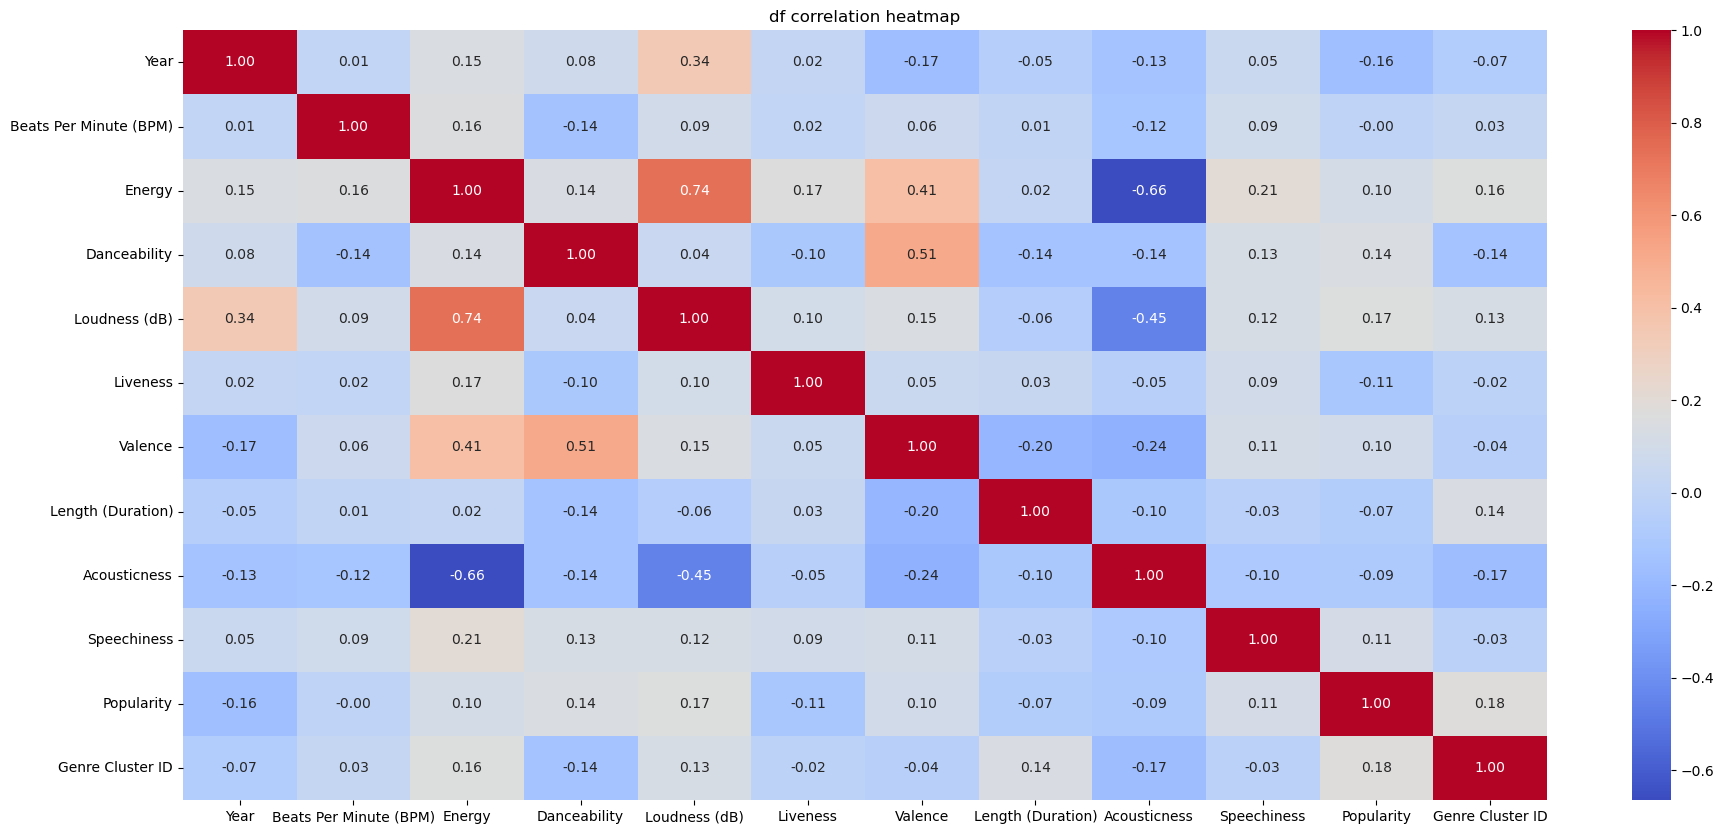

In [91]:
plt.figure(figsize=(22, 10))
plt.title('df correlation heatmap')
sns.heatmap(df[numeric_columns][1:].corr(), annot=True, cmap='coolwarm', cbar=True, fmt='.2f')
plt.show()

Most fields are not correlated to each other. The most correlated fields are 'Loudness (dB)' & 'Energy' and 'Acousticness' & 'Energy' and they have moderate correlations, not strong.

In [92]:
df['Top Genre'].value_counts(ascending=False).index[0]

'album rock'

In [93]:
df.loc[df['Top Genre']==df['Top Genre'].value_counts(ascending=False).index[0], ]

Title                        Artist  \
Index                                                                     
2                             Black Night                   Deep Purple   
14                         I'm going home               Ten Years After   
32                Big Log - 2006 Remaster                  Robert Plant   
60                        Goin To The Run                Golden Earring   
68                        In The Army Now                    Status Quo   
...                                   ...                           ...   
1977                   Down On The Corner  Creedence Clearwater Revival   
1980                             Touch Me                     The Doors   
1982                     Midnight Rambler            The Rolling Stones   
1984    Black Magic Woman - 2018 Remaster                 Fleetwood Mac   
1985   Suite: Judy Blue Eyes - Remastered         Crosby, Stills & Nash   

        Top Genre  Year  Beats Per Minute (BPM)  Energy  Danceability  \
Index                                                                   
2      album rock  2000                     135      79            50   
14     album rock  2005                     117      93            38   
32     album rock  2007                     181      59            56   
60     album rock  2008                     124      59            47   
68     album rock  2002                     105      73            68   
...           ...   ...                     ...     ...           ...   
1977   album rock  1969                     108      54            86   
1980   album rock  1969                     109      90            43   
1982   album rock  1969                      75      66            40   
1984   album rock  1969                     129      41            46   
1985   album rock  1969                     154      36            45   

       Loudness (dB)  Liveness  Valence  Length (Duration)  Acousticness  \
Index                                                                      
2                -11        17       81                207            17   
14                -2        81       40                639            18   
32                -9        20       68                306            32   
60                -8        28       18                236            42   
68                -8        14       94                281            11   
...              ...       ...      ...                ...           ...   
1977              -9         7       87                166            58   
1980              -5        12       77                190            41   
1982             -10        17       51                413            77   
1984             -11        28       44                173             5   
1985             -13        20       30                444            47   

       Speechiness  Popularity  Genre Cluster ID Genre Group  
Index                                                         
2                7          39                 2        Rock  
14              10          26                 2        Rock  
32               3          57                 2        Rock  
60               3          38                 2        Rock  
68               2          59                 2        Rock  
...            ...         ...               ...         ...  
1977             8          73                 2        Rock  
1980             7          68                 2        Rock  
1982            12          50                 2        Rock  
1984             4          48                 2        Rock  
1985             4          67                 2        Rock  

[413 rows x 16 columns]

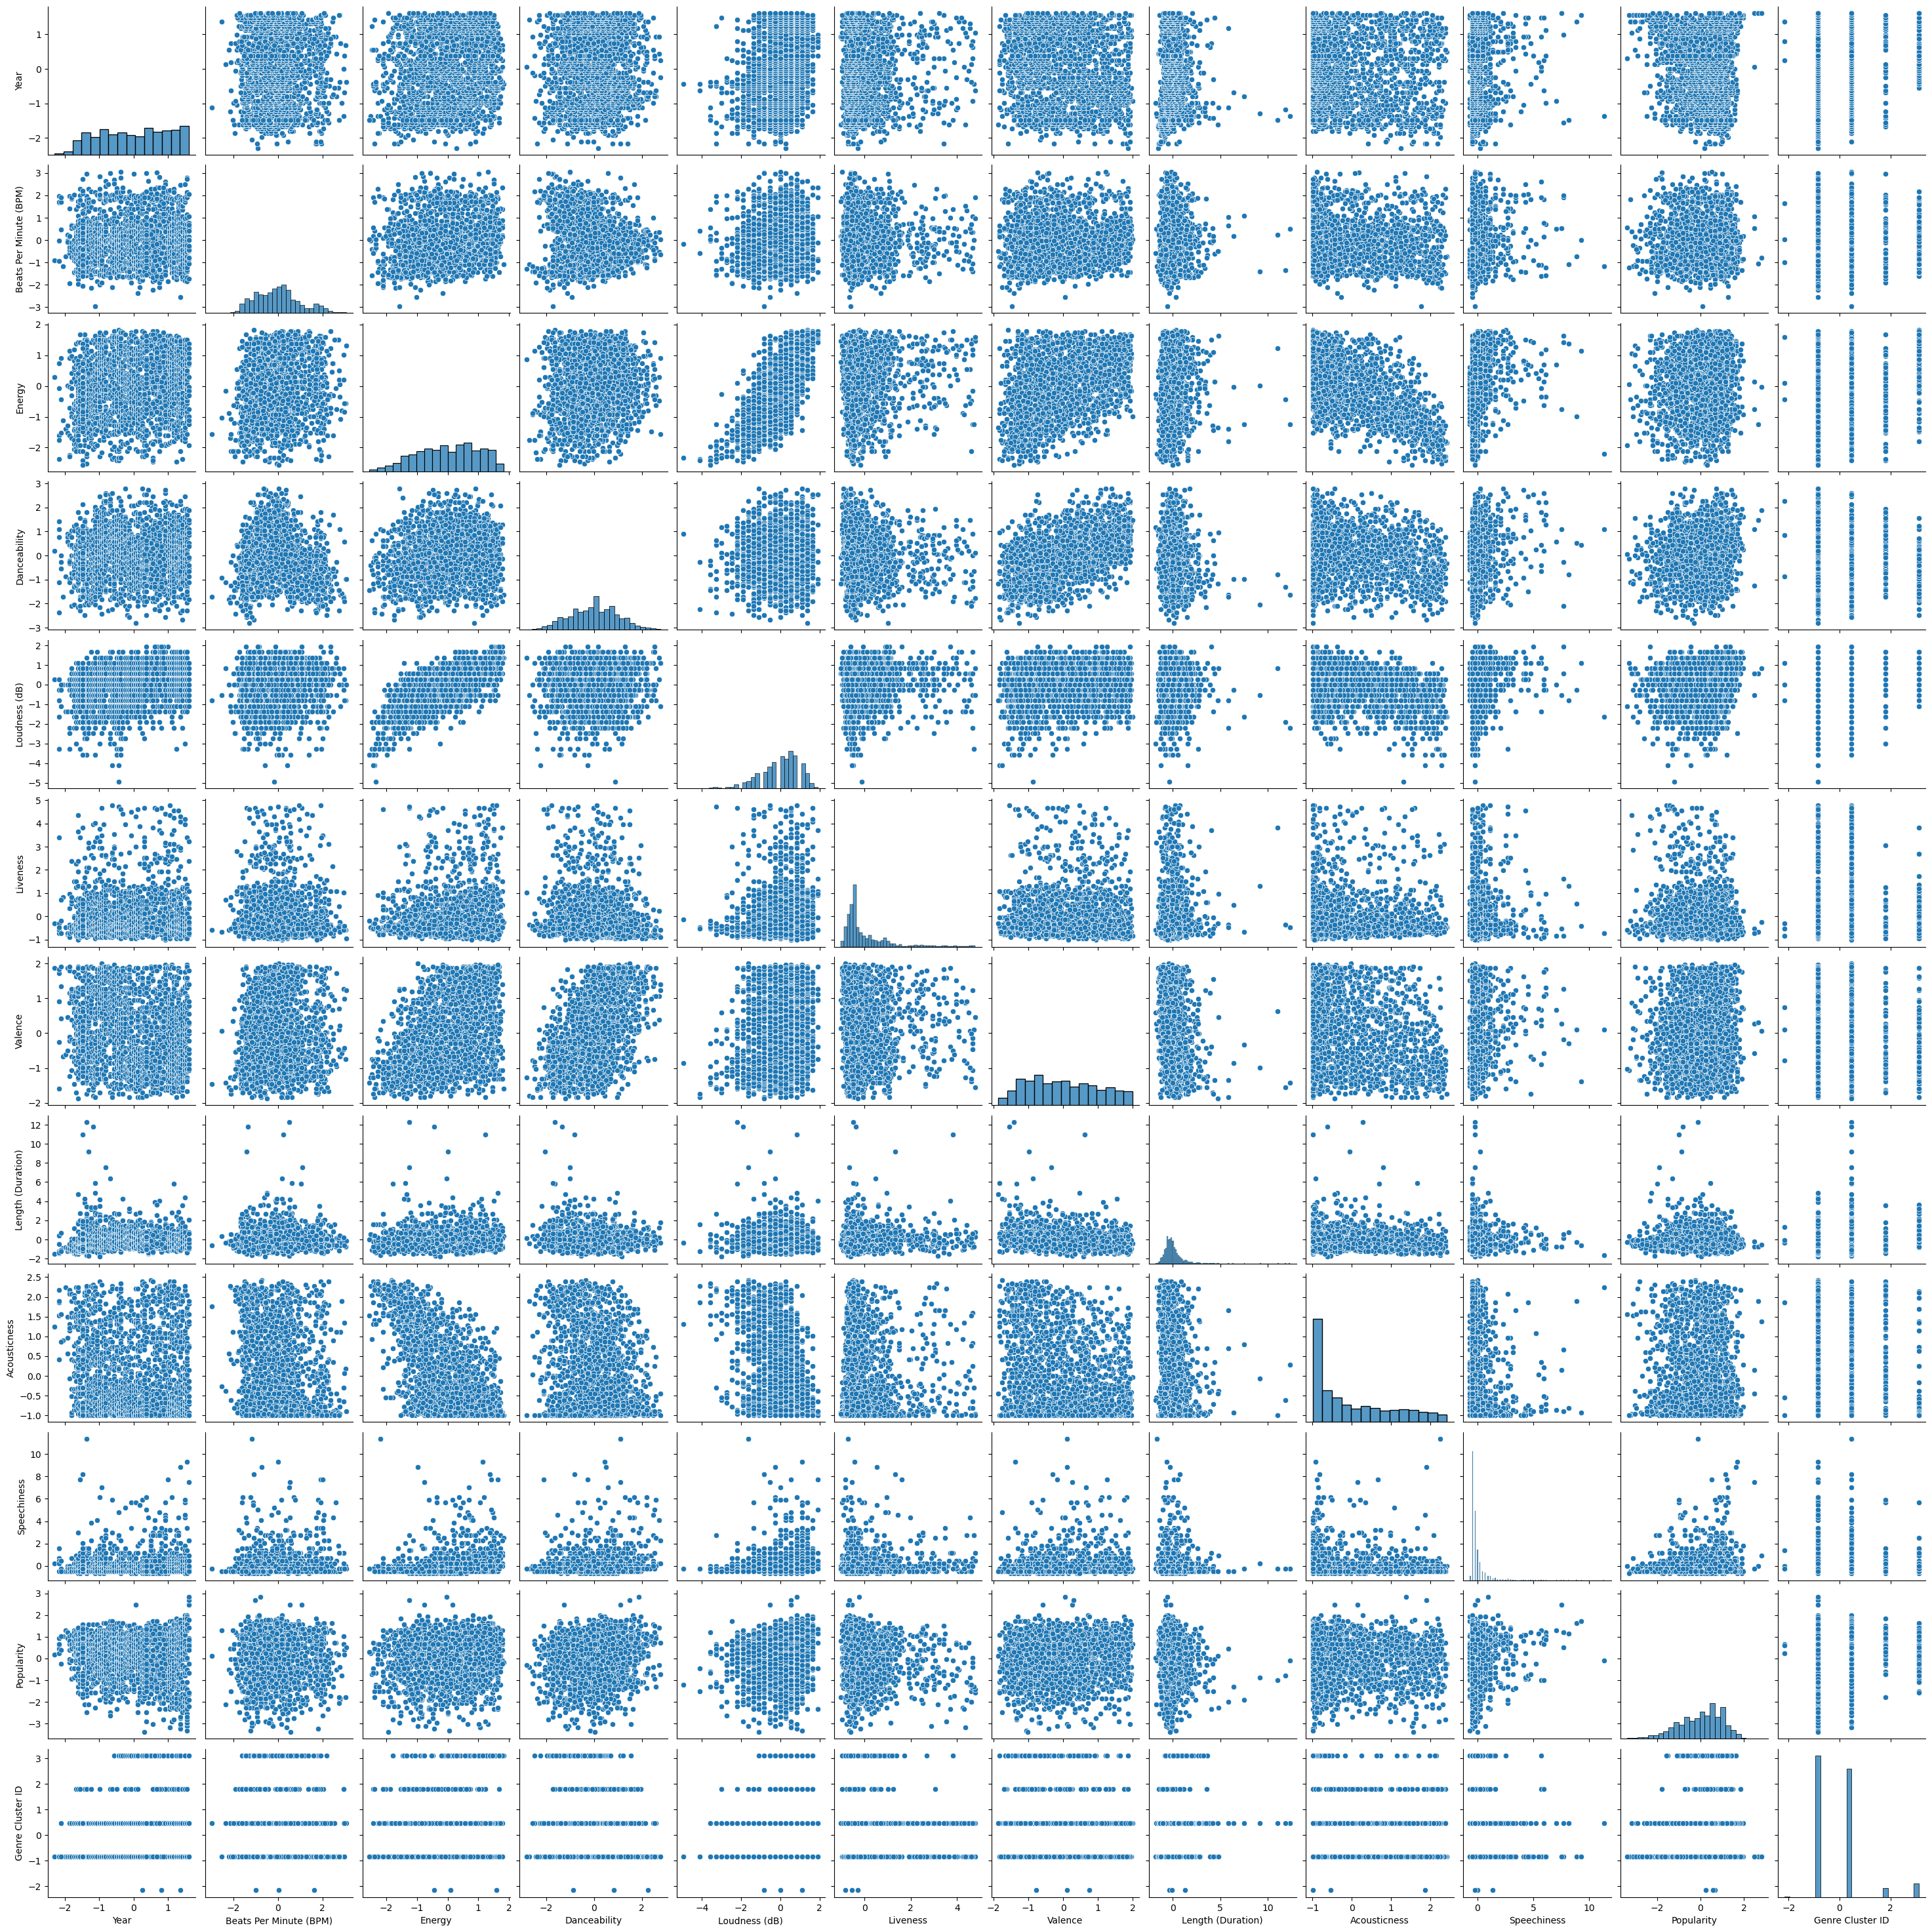

In [94]:
from sklearn.preprocessing import StandardScaler

original_df = df.copy()

# scaled_df = pd.DataFrame(StandardScaler().fit_transform(df[numeric_columns]), columns=numeric_columns)
# subset = df.loc[df['Top Genre']==df['Top Genre'].value_counts(ascending=False).index[0], ]
scaled_df = pd.DataFrame(StandardScaler().fit_transform(df[numeric_columns]), columns=numeric_columns)
sns.pairplot(scaled_df, kind='scatter')
plt.show()

## ML Preprocessing

In [95]:
top_genres = df['Top Genre'].value_counts(ascending=False).nlargest(10).index
filtered_df = df[df['Top Genre'].isin(top_genres)].sort_values('Top Genre', ascending=False).reset_index(drop=True)
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Title                   1092 non-null   object
 1   Artist                  1092 non-null   object
 2   Top Genre               1092 non-null   object
 3   Year                    1092 non-null   int64 
 4   Beats Per Minute (BPM)  1092 non-null   int64 
 5   Energy                  1092 non-null   int64 
 6   Danceability            1092 non-null   int64 
 7   Loudness (dB)           1092 non-null   int64 
 8   Liveness                1092 non-null   int64 
 9   Valence                 1092 non-null   int64 
 10  Length (Duration)       1092 non-null   int64 
 11  Acousticness            1092 non-null   int64 
 12  Speechiness             1092 non-null   int64 
 13  Popularity              1092 non-null   int64 
 14  Genre Cluster ID        1092 non-null   int64 
 15  Genr

Data is limited to the top ten genres in the dataset.

In [96]:
numeric_columns

['Year',
 'Beats Per Minute (BPM)',
 'Energy',
 'Danceability',
 'Loudness (dB)',
 'Liveness',
 'Valence',
 'Length (Duration)',
 'Acousticness',
 'Speechiness',
 'Popularity',
 'Genre Cluster ID']

In [97]:
X = filtered_df[numeric_columns[:-1]].to_numpy()
y = filtered_df["Top Genre"].to_numpy()

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [99]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [100]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)  

In [101]:
# 4. Define Models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42, n_estimators=100)
}

# 5. Train & Evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)
    print(f"\n{name}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²: {r2:.3f}")


Linear Regression
  RMSE: 2.39
  R²: 0.349

Decision Tree
  RMSE: 3.16
  R²: -0.132

Random Forest
  RMSE: 2.43
  R²: 0.328

Gradient Boosting
  RMSE: 2.46
  R²: 0.310


In [102]:
# Store model performance results
performance_regression = []

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    preds_test = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds_test, squared=False)

    performance_regression.append({
        "Model": name,
        "RMSE": round(rmse, 2),
        "Training Time (s)": round(train_time, 4)
    })

# Convert to DataFrame and sort by RMSE
performance_df_regression = pd.DataFrame(performance_regression).sort_values(by="RMSE")

# Display the performance
print("Model Speed and Quality (Regression):")
display(performance_df_regression)

Model Speed and Quality (Regression):


Model  RMSE  Training Time (s)
0  Linear Regression  2.39             0.0035
2      Random Forest  2.43             0.4610
3  Gradient Boosting  2.46             0.1464
1      Decision Tree  3.16             0.0073

In [103]:
prediction_speeds = []

# Fit and time predictions on X_test
for name, model in models.items():
    model.fit(X_train, y_train)
    start_time = time.time()
    _ = model.predict(X_test)
    prediction_time = time.time() - start_time
    prediction_speeds.append({
        "Model": name,
        "Prediction Time (s)": round(prediction_time, 4)
    })

# Display results sorted by prediction time
prediction_speed_df = pd.DataFrame(prediction_speeds).sort_values(by="Prediction Time (s)")

print("Prediction Speed Comparison")
display(prediction_speed_df)

Prediction Speed Comparison


Model  Prediction Time (s)
3  Gradient Boosting               0.0000
0  Linear Regression               0.0010
1      Decision Tree               0.0010
2      Random Forest               0.0053

In [104]:
# Use the previously prepared training and test data
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
test_predictions = model.predict(X_test)

# Calculate RMSE on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("Test RMSE (Linear Regression):", round(test_rmse, 2))

Test RMSE (Linear Regression): 2.39
